In [1]:
# imports
import torch
import torch.nn
import torch.optim
from torch.autograd import Variable
import torch.autograd
import numpy
import torchvision.datasets
import torchvision.transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot
import datetime
import os
import tkinter
from tkinter import filedialog

In [45]:
# variables
DOWNLOAD = False
EPOCH = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# custom function
def plotArray(array1, array2, name1, name2):
    matplotlib.pyplot.plot(array1, label=name1, color='#0000FF')
    matplotlib.pyplot.plot(array2, label=name2, color='#FF0000')
    matplotlib.pyplot.legend(loc='best')
    matplotlib.pyplot.show()
    matplotlib.pyplot.clf()


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


# 辨別連續特徵：筆劃粗細、傾斜角度
class log_gaussian:
    def __call__(self, x, mu, var):

        logli = -0.5 * (var.mul(2 * numpy.pi) + 1e-6).log() - (
            x - mu).pow(2).div(var.mul(2.0) + 1e-6)

        return logli.sum(1).mean().mul(-1)


class Trainer:
    def __init__(self, G, FE, D, Q):

        self.G = G
        self.FE = FE
        self.D = D
        self.Q = Q

        self.batch_size = 100

    def _noise_sample(self, dis_c, con_c, noise, bs):

        idx = numpy.random.randint(10, size=bs)
        c = numpy.zeros((bs, 10))
        c[range(bs), idx] = 1.0

        dis_c.data.copy_(torch.Tensor(c))
        con_c.data.uniform_(-1.0, 1.0)
        noise.data.uniform_(-1.0, 1.0)
        z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)

        return z, idx

    def train(self, path, condition):
        os.mkdir(PATH)
        DLoss = []
        GLoss = []

        # MNIST data dimension: 28*28
        real_x = torch.FloatTensor(self.batch_size, 1, 28, 28).to(device)
        label = torch.FloatTensor(self.batch_size, 1).to(device)
        dis_c = torch.FloatTensor(self.batch_size, 10).to(device)
        con_c = torch.FloatTensor(self.batch_size, 2).to(device)
        noise = torch.FloatTensor(self.batch_size, 62).to(device)

        real_x = Variable(real_x)
        label = Variable(label, requires_grad=False)
        dis_c = Variable(dis_c)
        con_c = Variable(con_c)
        noise = Variable(noise)

        # binary classify
        criterionD = torch.nn.BCELoss().to(device)
        criterionQ_dis = torch.nn.CrossEntropyLoss().to(device)
        criterionQ_con = log_gaussian()

        optimD = torch.optim.Adam([{
            'params': self.FE.parameters()
        }, {
            'params': self.D.parameters()
        }],
                                  lr=0.0002,
                                  betas=(0.5, 0.99))
        optimG = torch.optim.Adam([{
            'params': self.G.parameters()
        }, {
            'params': self.Q.parameters()
        }],
                                  lr=0.001,
                                  betas=(0.5, 0.99))

        # download MNIST dataset
        dataset = torchvision.datasets.MNIST(
            './dataset',
            transform=torchvision.transforms.ToTensor(),
            download=DOWNLOAD)
        dataloader = DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True, num_workers=1)

        # fixed random variables
        c = numpy.linspace(-1, 1, 10).reshape(1, -1)
        c = numpy.repeat(c, 10, 0).reshape(-1, 1)

        c1 = numpy.hstack([c, numpy.zeros_like(c)])
        c2 = numpy.hstack([numpy.zeros_like(c), c])

        # 控制生成數字
        if condition == -1:
            idx = numpy.arange(10).repeat(10)
        else:
            idx = numpy.array(condition).repeat(100)
        one_hot = numpy.zeros((100, 10))
        one_hot[range(100), idx] = 1
        fix_noise = torch.Tensor(100, 62).uniform_(-1, 1)

        for epoch in range(EPOCH):
            for num_iters, batch_data in enumerate(dataloader, 0):

                # real part
                optimD.zero_grad()

                x, _ = batch_data

                bs = x.size(0)
                real_x.data.resize_(x.size())
                label.data.resize_(bs, 1)
                dis_c.data.resize_(bs, 10)
                con_c.data.resize_(bs, 2)
                noise.data.resize_(bs, 62)

                real_x.data.copy_(x)
                fe_out1 = self.FE(real_x)
                probs_real = self.D(fe_out1)
                label.data.fill_(1)
                # 真實的資料放入辨識模型 與 真實分佈1 的距離
                loss_real = criterionD(probs_real, label)
                loss_real.backward()

                # fake part
                # 放入生成模型的雜訊
                z, idx = self._noise_sample(dis_c, con_c, noise, bs)
                fake_x = self.G(z)
                fe_out2 = self.FE(fake_x.detach())
                probs_fake = self.D(fe_out2)
                label.data.fill_(0)
                # 生成的假資料放入辨識模型 與 假資料分佈0 的距離
                loss_fake = criterionD(probs_fake, label)
                loss_fake.backward()

                # 兩者Loss都應該趨近0(接近想要的分佈)
                # 更新辨識模型
                D_loss = loss_real + loss_fake

                optimD.step()

                # G and Q part
                optimG.zero_grad()

                fe_out = self.FE(fake_x)
                probs_fake = self.D(fe_out)
                label.data.fill_(1.0)

                # 重建後的假資料放入辨識模型 與 真實分佈1 的距離
                reconstruct_loss = criterionD(probs_fake, label)

                # 輸入與輸出的依賴程度
                q_logits, q_mu, q_var = self.Q(fe_out)
                class_ = torch.LongTensor(idx).to(device)
                target = Variable(class_)
                # 先驗機率 與 後驗機率 分佈狀況的距離
                dis_loss = criterionQ_dis(q_logits, target)
                # 分類狀況的距離
                con_loss = criterionQ_con(con_c, q_mu, q_var) * 0.1

                # 更新生成模型
                G_loss = reconstruct_loss + dis_loss + con_loss
                G_loss.backward()
                optimG.step()

                if num_iters % 100 == 0:

                    print('Epoch/Iter:{0}/{1}, Dloss: {2}, Gloss: {3}'.format(
                        epoch, num_iters,
                        D_loss.data.cpu().numpy(),
                        G_loss.data.cpu().numpy()))

                    # plot loss array
                    DLoss.append(D_loss.data.cpu().numpy())
                    GLoss.append(G_loss.data.cpu().numpy())

                    # save image
                    noise.data.copy_(fix_noise)
                    dis_c.data.copy_(torch.Tensor(one_hot))

                    # 連續變量：寬度
                    con_c.data.copy_(torch.from_numpy(c1))
                    z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
                    x_save = self.G(z)
                    save_image(
                        x_save.data,
                        path + '/c1_' + str(epoch) + '_' + str(num_iters) +
                        '.png',
                        nrow=10)

                    # 連續變量：旋轉
                    con_c.data.copy_(torch.from_numpy(c2))
                    z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
                    x_save = self.G(z)
                    save_image(
                        x_save.data,
                        path + '/c2_' + str(epoch) + '_' + str(num_iters) +
                        '.png',
                        nrow=10)

        return DLoss, GLoss

In [4]:
# InfoGAN model
# 整體架構
class FE(torch.nn.Module):
    ''' front end part of discriminator and Q'''

    def __init__(self):
        super(FE, self).__init__()

        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 4, 2, 1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(128, 1024, 7, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self, x):
        output = self.main(x)
        return output

# 判別模型：判斷圖像真實性
# 輸入：假資料 和 真實資料
# 輸出：維度1的機率，值為0(假)~1(真實)
class D(torch.nn.Module):
    def __init__(self):
        super(D, self).__init__()

        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(1024, 1, 1), torch.nn.Sigmoid())

    def forward(self, x):
        output = self.main(x).view(-1, 1)
        return output


# 分類器：在雜訊中Cat進去的Condition 與 生成的假資料 的依賴程度
# 確保模型沒有將數字分類0~9的Condition當成一般雜訊過濾掉
class Q(torch.nn.Module):
    def __init__(self):
        super(Q, self).__init__()

        self.conv = torch.nn.Conv2d(1024, 128, 1, bias=False)
        self.bn = torch.nn.BatchNorm2d(128)
        self.lReLU = torch.nn.LeakyReLU(0.1, inplace=True)
        self.conv_disc = torch.nn.Conv2d(128, 10, 1)
        self.conv_mu = torch.nn.Conv2d(128, 2, 1)
        self.conv_var = torch.nn.Conv2d(128, 2, 1)

    def forward(self, x):

        y = self.conv(x)

        disc_logits = self.conv_disc(y).squeeze()

        mu = self.conv_mu(y).squeeze()
        var = self.conv_var(y).squeeze().exp()

        return disc_logits, mu, var


# 生成模型：配合雜訊生成假資料
class G(torch.nn.Module):
    def __init__(self):
        super(G, self).__init__()

        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(74, 1024, 1, 1, bias=False),
            torch.nn.BatchNorm2d(1024), torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(1024, 128, 7, 1, bias=False),
            torch.nn.BatchNorm2d(128), torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64), torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            torch.nn.Sigmoid())

    def forward(self, x):
        output = self.main(x)
        return output

In [5]:
# DCGAN model
# as same as InfoGAN
class FrondEnd(torch.nn.Module):
    ''' front end part of discriminator and Q'''

    def __init__(self):
        super(FrondEnd, self).__init__()

        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 4, 2, 1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(128, 1024, 7, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self, x):
        output = self.main(x)
        return output


class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(74, 512, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),
            # change size
            torch.nn.ConvTranspose2d(128, 1, 4, 2, 3, bias=False),
            #torch.nn.BatchNorm2d(64),
            #torch.nn.ReLU(True),
            #torch.nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            torch.nn.Tanh())

    def forward(self, input):
        output = torch.nn.parallel.data_parallel(self.main, input, range(1))
        return output


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(1024, 64, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid())
        
        self.main2 = torch.nn.Sequential(
            torch.nn.Conv2d(1024, 1, 1), torch.nn.Sigmoid())

    def forward(self, input):
#         output = torch.nn.parallel.data_parallel(self.main, input, range(1))
#         output = output.view(-1, 1).squeeze(1)
        output = self.main2(input)
        return output

In [8]:
# models information
# InfoGAN
fe = FE()
g = G()
d = D()
# GCGAN
frondend = FrondEnd()
generator = Generator()
discriminator = Discriminator()
for i in [fe, frondend, g, generator, d, discriminator]:
    print(i)

FE(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1, inplace)
    (5): Conv2d(128, 1024, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1, inplace)
  )
)
FrondEnd(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1, inplace)
    (5): Conv2d(128, 1024, 

Epoch/Iter:0/0, Dloss: 1.4287993907928467, Gloss: 3.185560941696167
Epoch/Iter:0/100, Dloss: 1.0593376159667969, Gloss: 1.4977303743362427
Epoch/Iter:0/200, Dloss: 0.8420780897140503, Gloss: 1.4279640913009644
Epoch/Iter:0/300, Dloss: 1.1477532386779785, Gloss: 1.0173455476760864
Epoch/Iter:0/400, Dloss: 1.1628668308258057, Gloss: 0.9938313961029053
Epoch/Iter:0/500, Dloss: 1.2406514883041382, Gloss: 1.0352789163589478
Epoch/Iter:1/0, Dloss: 1.1197822093963623, Gloss: 1.0144824981689453
Epoch/Iter:1/100, Dloss: 1.1567965745925903, Gloss: 0.9110952615737915
Epoch/Iter:1/200, Dloss: 1.1385178565979004, Gloss: 0.8821542859077454
Epoch/Iter:1/300, Dloss: 1.2066067457199097, Gloss: 1.0402323007583618
Epoch/Iter:1/400, Dloss: 1.188650131225586, Gloss: 0.9705224633216858
Epoch/Iter:1/500, Dloss: 1.17949640750885, Gloss: 0.8869239091873169
Epoch/Iter:2/0, Dloss: 1.2186496257781982, Gloss: 0.9059638381004333
Epoch/Iter:2/100, Dloss: 1.1671308279037476, Gloss: 0.9600182175636292
Epoch/Iter:2/200

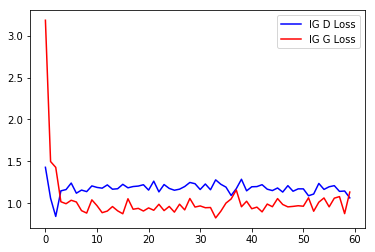

<Figure size 432x288 with 0 Axes>

In [34]:
# InfoGAN main
fe = FE()
d = D()
q = Q()
g = G()
IG_DLossArray = []
IG_GLossArray = []

for i in [fe, d, q, g]:
    i.to(device)
    i.apply(weights_init)

trainer = Trainer(g, fe, d, q)
IG_DLossArray, IG_GLossArray = trainer.train()
plotArray(IG_DLossArray, IG_GLossArray, 'IG D Loss', 'IG G Loss')

Epoch/Iter:0/0, Dloss: 1.4225409030914307, Gloss: 3.3277955055236816
Epoch/Iter:0/100, Dloss: 0.848156750202179, Gloss: 1.2707607746124268
Epoch/Iter:0/200, Dloss: 0.9107682108879089, Gloss: 1.317918062210083
Epoch/Iter:0/300, Dloss: 1.0034277439117432, Gloss: 1.111016869544983
Epoch/Iter:0/400, Dloss: 1.1049714088439941, Gloss: 1.056882381439209
Epoch/Iter:0/500, Dloss: 1.0240838527679443, Gloss: 1.1342628002166748
Epoch/Iter:1/0, Dloss: 0.9731968641281128, Gloss: 1.2290537357330322
Epoch/Iter:1/100, Dloss: 1.0604749917984009, Gloss: 1.1227842569351196
Epoch/Iter:1/200, Dloss: 1.0347800254821777, Gloss: 1.1582998037338257
Epoch/Iter:1/300, Dloss: 0.9634897112846375, Gloss: 1.1130577325820923
Epoch/Iter:1/400, Dloss: 1.1591392755508423, Gloss: 1.2814162969589233
Epoch/Iter:1/500, Dloss: 1.0930626392364502, Gloss: 1.051016092300415
Epoch/Iter:2/0, Dloss: 1.0634560585021973, Gloss: 1.1834627389907837
Epoch/Iter:2/100, Dloss: 1.0935015678405762, Gloss: 1.0861257314682007
Epoch/Iter:2/200,

Epoch/Iter:38/200, Dloss: 0.6552958488464355, Gloss: 2.200535297393799
Epoch/Iter:38/300, Dloss: 0.6683611869812012, Gloss: 2.230114221572876
Epoch/Iter:38/400, Dloss: 0.57679283618927, Gloss: 2.328554630279541
Epoch/Iter:38/500, Dloss: 0.6270738840103149, Gloss: 2.0817484855651855
Epoch/Iter:39/0, Dloss: 0.6331923007965088, Gloss: 2.209693670272827
Epoch/Iter:39/100, Dloss: 0.663550615310669, Gloss: 2.0846128463745117
Epoch/Iter:39/200, Dloss: 0.7128669023513794, Gloss: 2.0017900466918945
Epoch/Iter:39/300, Dloss: 0.7467849254608154, Gloss: 2.1977648735046387
Epoch/Iter:39/400, Dloss: 0.693482518196106, Gloss: 2.2192647457122803
Epoch/Iter:39/500, Dloss: 0.756991982460022, Gloss: 1.9942430257797241
Epoch/Iter:40/0, Dloss: 0.6343183517456055, Gloss: 2.3772716522216797
Epoch/Iter:40/100, Dloss: 0.7865263223648071, Gloss: 2.058089256286621
Epoch/Iter:40/200, Dloss: 0.8840214014053345, Gloss: 2.2822062969207764
Epoch/Iter:40/300, Dloss: 0.6712743043899536, Gloss: 2.0522050857543945
Epoch/

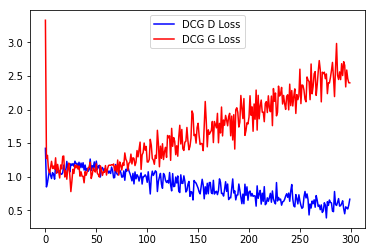

Epoch/Iter:0/0, Dloss: 1.4188594818115234, Gloss: 3.3404176235198975
Epoch/Iter:0/100, Dloss: 0.9306775331497192, Gloss: 1.2352793216705322
Epoch/Iter:0/200, Dloss: 1.0041868686676025, Gloss: 1.1786329746246338
Epoch/Iter:0/300, Dloss: 0.9806206226348877, Gloss: 1.0852546691894531
Epoch/Iter:0/400, Dloss: 0.941998302936554, Gloss: 1.1667284965515137
Epoch/Iter:0/500, Dloss: 1.0454124212265015, Gloss: 1.1921290159225464
Epoch/Iter:1/0, Dloss: 0.9633128643035889, Gloss: 1.1782383918762207
Epoch/Iter:1/100, Dloss: 0.9591227769851685, Gloss: 1.041993260383606
Epoch/Iter:1/200, Dloss: 1.019836664199829, Gloss: 1.1770046949386597
Epoch/Iter:1/300, Dloss: 1.046401023864746, Gloss: 1.1354048252105713
Epoch/Iter:1/400, Dloss: 0.9507088661193848, Gloss: 1.1365879774093628
Epoch/Iter:1/500, Dloss: 0.984745979309082, Gloss: 1.0867899656295776
Epoch/Iter:2/0, Dloss: 1.0078434944152832, Gloss: 1.300187349319458
Epoch/Iter:2/100, Dloss: 1.0436744689941406, Gloss: 1.3107446432113647
Epoch/Iter:2/200, 

Epoch/Iter:38/200, Dloss: 0.6696863174438477, Gloss: 1.9375230073928833
Epoch/Iter:38/300, Dloss: 0.6118330955505371, Gloss: 2.0199661254882812
Epoch/Iter:38/400, Dloss: 0.788426399230957, Gloss: 1.9196069240570068
Epoch/Iter:38/500, Dloss: 0.7595452070236206, Gloss: 1.912561297416687
Epoch/Iter:39/0, Dloss: 0.7797665596008301, Gloss: 2.271469831466675
Epoch/Iter:39/100, Dloss: 0.7747682332992554, Gloss: 2.187788486480713
Epoch/Iter:39/200, Dloss: 0.6231565475463867, Gloss: 2.359964609146118
Epoch/Iter:39/300, Dloss: 0.47562408447265625, Gloss: 2.533033609390259
Epoch/Iter:39/400, Dloss: 0.6876854300498962, Gloss: 1.9063886404037476
Epoch/Iter:39/500, Dloss: 0.7669386863708496, Gloss: 1.8242894411087036
Epoch/Iter:40/0, Dloss: 0.5191121697425842, Gloss: 2.357485294342041
Epoch/Iter:40/100, Dloss: 0.4684728980064392, Gloss: 2.35223388671875
Epoch/Iter:40/200, Dloss: 0.6087660789489746, Gloss: 2.0201575756073
Epoch/Iter:40/300, Dloss: 0.6522850394248962, Gloss: 2.3195197582244873
Epoch/I

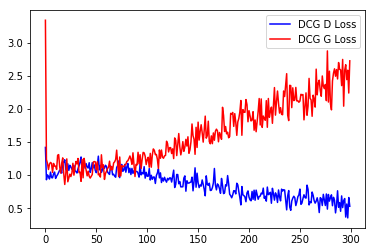

Epoch/Iter:0/0, Dloss: 1.4200739860534668, Gloss: 3.2865004539489746
Epoch/Iter:0/100, Dloss: 1.191954493522644, Gloss: 1.4662729501724243
Epoch/Iter:0/200, Dloss: 0.995032548904419, Gloss: 1.1839628219604492
Epoch/Iter:0/300, Dloss: 1.118999719619751, Gloss: 1.0565640926361084
Epoch/Iter:0/400, Dloss: 1.0792407989501953, Gloss: 1.0251926183700562
Epoch/Iter:0/500, Dloss: 0.9632343053817749, Gloss: 1.1769980192184448
Epoch/Iter:1/0, Dloss: 1.0003368854522705, Gloss: 1.170931339263916
Epoch/Iter:1/100, Dloss: 1.0428364276885986, Gloss: 1.080290675163269
Epoch/Iter:1/200, Dloss: 1.043375015258789, Gloss: 1.10050368309021
Epoch/Iter:1/300, Dloss: 1.0169398784637451, Gloss: 1.211053729057312
Epoch/Iter:1/400, Dloss: 1.0832371711730957, Gloss: 1.114424228668213
Epoch/Iter:1/500, Dloss: 1.0420032739639282, Gloss: 0.9829302430152893
Epoch/Iter:2/0, Dloss: 0.9847713708877563, Gloss: 1.1552865505218506
Epoch/Iter:2/100, Dloss: 1.0522780418395996, Gloss: 1.0158647298812866
Epoch/Iter:2/200, Dlos

Epoch/Iter:38/200, Dloss: 0.5326569676399231, Gloss: 2.1602742671966553
Epoch/Iter:38/300, Dloss: 0.6422696113586426, Gloss: 2.282555103302002
Epoch/Iter:38/400, Dloss: 0.6710361838340759, Gloss: 2.017385721206665
Epoch/Iter:38/500, Dloss: 0.7651103138923645, Gloss: 2.0509302616119385
Epoch/Iter:39/0, Dloss: 0.6031940579414368, Gloss: 2.3520069122314453
Epoch/Iter:39/100, Dloss: 0.6693167090415955, Gloss: 2.220031261444092
Epoch/Iter:39/200, Dloss: 0.7525818943977356, Gloss: 1.9163058996200562
Epoch/Iter:39/300, Dloss: 0.5981632471084595, Gloss: 2.1583597660064697
Epoch/Iter:39/400, Dloss: 0.6876310706138611, Gloss: 1.9800848960876465
Epoch/Iter:39/500, Dloss: 0.546980619430542, Gloss: 2.409801959991455
Epoch/Iter:40/0, Dloss: 0.6204910278320312, Gloss: 2.2591001987457275
Epoch/Iter:40/100, Dloss: 0.608245313167572, Gloss: 2.2573635578155518
Epoch/Iter:40/200, Dloss: 0.6754673719406128, Gloss: 2.290886402130127
Epoch/Iter:40/300, Dloss: 0.6330418586730957, Gloss: 2.3503642082214355
Epo

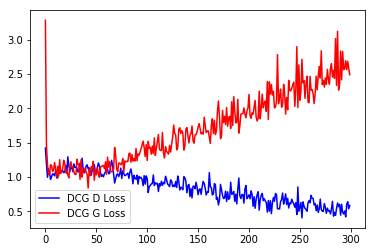

Epoch/Iter:0/0, Dloss: 1.465997338294983, Gloss: 3.449918746948242
Epoch/Iter:0/100, Dloss: 0.9152379631996155, Gloss: 1.2667628526687622
Epoch/Iter:0/200, Dloss: 0.80405592918396, Gloss: 1.3629368543624878
Epoch/Iter:0/300, Dloss: 0.99286949634552, Gloss: 1.1322327852249146
Epoch/Iter:0/400, Dloss: 1.043302297592163, Gloss: 1.3304023742675781
Epoch/Iter:0/500, Dloss: 0.918400764465332, Gloss: 1.3779364824295044
Epoch/Iter:1/0, Dloss: 0.9487042427062988, Gloss: 1.326047658920288
Epoch/Iter:1/100, Dloss: 0.9780435562133789, Gloss: 1.4014290571212769
Epoch/Iter:1/200, Dloss: 0.9147320985794067, Gloss: 1.3798305988311768
Epoch/Iter:1/300, Dloss: 0.8845760822296143, Gloss: 1.255562424659729
Epoch/Iter:1/400, Dloss: 1.0294139385223389, Gloss: 1.0844038724899292
Epoch/Iter:1/500, Dloss: 1.2194409370422363, Gloss: 1.2929916381835938
Epoch/Iter:2/0, Dloss: 0.9658083319664001, Gloss: 1.2873879671096802
Epoch/Iter:2/100, Dloss: 0.9855170249938965, Gloss: 1.3020377159118652
Epoch/Iter:2/200, Dlos

Epoch/Iter:38/200, Dloss: 0.6931948065757751, Gloss: 2.622868776321411
Epoch/Iter:38/300, Dloss: 0.5303200483322144, Gloss: 2.275871992111206
Epoch/Iter:38/400, Dloss: 0.7494021058082581, Gloss: 2.1192195415496826
Epoch/Iter:38/500, Dloss: 0.6021324992179871, Gloss: 2.356217861175537
Epoch/Iter:39/0, Dloss: 0.5113369226455688, Gloss: 2.5607869625091553
Epoch/Iter:39/100, Dloss: 0.6592309474945068, Gloss: 1.9219599962234497
Epoch/Iter:39/200, Dloss: 0.6778079867362976, Gloss: 2.358823776245117
Epoch/Iter:39/300, Dloss: 0.6930082440376282, Gloss: 2.0212674140930176
Epoch/Iter:39/400, Dloss: 0.6488873958587646, Gloss: 2.0887887477874756
Epoch/Iter:39/500, Dloss: 0.728219747543335, Gloss: 2.386568784713745
Epoch/Iter:40/0, Dloss: 0.530823826789856, Gloss: 2.6736693382263184
Epoch/Iter:40/100, Dloss: 0.5479701161384583, Gloss: 2.64579439163208
Epoch/Iter:40/200, Dloss: 0.5838258862495422, Gloss: 2.3022162914276123
Epoch/Iter:40/300, Dloss: 0.5204168558120728, Gloss: 2.195993661880493
Epoch/

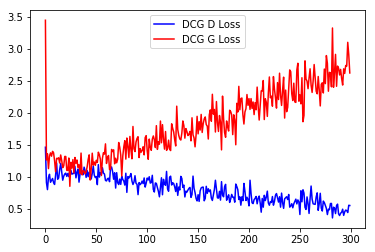

Epoch/Iter:0/0, Dloss: 1.4775309562683105, Gloss: 3.469682455062866
Epoch/Iter:0/100, Dloss: 0.8822509050369263, Gloss: 1.3454391956329346
Epoch/Iter:0/200, Dloss: 0.7364797592163086, Gloss: 1.5176610946655273
Epoch/Iter:0/300, Dloss: 1.0366811752319336, Gloss: 1.1223082542419434
Epoch/Iter:0/400, Dloss: 1.050249457359314, Gloss: 1.11247980594635
Epoch/Iter:0/500, Dloss: 0.9910002946853638, Gloss: 1.13943350315094
Epoch/Iter:1/0, Dloss: 1.0349496603012085, Gloss: 1.2091118097305298
Epoch/Iter:1/100, Dloss: 0.9966462850570679, Gloss: 1.1871362924575806
Epoch/Iter:1/200, Dloss: 0.9452707171440125, Gloss: 1.1684142351150513
Epoch/Iter:1/300, Dloss: 0.999301552772522, Gloss: 1.1575087308883667
Epoch/Iter:1/400, Dloss: 1.075960397720337, Gloss: 1.0637316703796387
Epoch/Iter:1/500, Dloss: 0.9677520990371704, Gloss: 1.1704086065292358
Epoch/Iter:2/0, Dloss: 1.045194387435913, Gloss: 1.2048637866973877
Epoch/Iter:2/100, Dloss: 1.0842387676239014, Gloss: 1.2933253049850464
Epoch/Iter:2/200, Dlo

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [46]:
# main of change InfoGan G and D to DCGAN Generator and Discriminator
for i in range(10):
    frondend = FrondEnd()
    discriminator = Discriminator()
    q = Q()
    generator = Generator()

    DCG_DLossArray = []
    DCG_GLossArray = []
    TIME = str(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    PATH = 'C:/Users/b0343/Desktop/Lab4/tmp/' + str(TIME)

    for i in [frondend, discriminator, q, generator]:
        i.to(device)
        i.apply(weights_init)

    trainer = Trainer(generator, frondend, discriminator, q)
    DCG_DLossArray, DCG_GLossArray = trainer.train(PATH, -1)
    plotArray(DCG_DLossArray, DCG_GLossArray, 'DCG D Loss', 'DCG G Loss')

    # save model weight
    torch.save(frondend.state_dict(), PATH + '/frondend_' + str(TIME) + '.pt')
    torch.save(discriminator.state_dict(),
               PATH + '/discriminator_' + str(TIME) + '.pt')
    torch.save(q.state_dict(), PATH + '/q_' + str(TIME) + '.pt')
    torch.save(generator.state_dict(), PATH + '/generator_' + str(TIME) + '.pt')

In [59]:
# test result
# load model weight
root = tkinter.Tk()
root.withdraw()
root.wm_attributes("-topmost", 1)
modelName = ['Discriminator', 'FrondEnd', 'Generator', 'Q']
fileName = []
for i in range(len(modelName)):
    file = filedialog.askopenfilename(
        parent=root,
        title=modelName[i] + ' Model Weight',
        filetypes=[("Model Weight", ".pt")],
        multiple=False)
    fileName.append(file)

testFrondend = FrondEnd()
testDiscriminator = Discriminator()
testQ = Q()
testGenerator = Generator()

count = 0
for i in [testDiscriminator, testFrondend, testGenerator, testQ]:
    i.to(device)
    #     i.apply(weights_init)
    i.load_state_dict(torch.load(fileName[count]))
    count += 1

# condition result
PATH = fileName[0].split('discriminator')[0]


class Testner:
    def __init__(self, G, FE, D, Q):

        self.G = G
        self.FE = FE
        self.D = D
        self.Q = Q

        self.batch_size = 100

    def _noise_sample(self, dis_c, con_c, noise, bs):

        idx = numpy.random.randint(10, size=bs)
        c = numpy.zeros((bs, 10))
        c[range(bs), idx] = 1.0

        dis_c.data.copy_(torch.Tensor(c))
        con_c.data.uniform_(-1.0, 1.0)
        noise.data.uniform_(-1.0, 1.0)
        z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)

        return z, idx

    def test(self, path, condition):
        # MNIST data dimension: 28*28
        real_x = torch.FloatTensor(self.batch_size, 1, 28, 28).to(device)
        label = torch.FloatTensor(self.batch_size, 1).to(device)
        dis_c = torch.FloatTensor(self.batch_size, 10).to(device)
        con_c = torch.FloatTensor(self.batch_size, 2).to(device)
        noise = torch.FloatTensor(self.batch_size, 62).to(device)

        real_x = Variable(real_x)
        label = Variable(label, requires_grad=False)
        dis_c = Variable(dis_c)
        con_c = Variable(con_c)
        noise = Variable(noise)

        # binary classify
        criterionD = torch.nn.BCELoss().to(device)
        criterionQ_dis = torch.nn.CrossEntropyLoss().to(device)
        criterionQ_con = log_gaussian()

        optimD = torch.optim.Adam([{
            'params': self.FE.parameters()
        }, {
            'params': self.D.parameters()
        }],
                                  lr=0.0002,
                                  betas=(0.5, 0.99))
        optimG = torch.optim.Adam([{
            'params': self.G.parameters()
        }, {
            'params': self.Q.parameters()
        }],
                                  lr=0.001,
                                  betas=(0.5, 0.99))

        # download MNIST dataset
        dataset = torchvision.datasets.MNIST(
            './dataset',
            transform=torchvision.transforms.ToTensor(),
            download=DOWNLOAD)
        dataloader = DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True, num_workers=1)

        # fixed random variables
        c = numpy.linspace(-1, 1, 10).reshape(1, -1)
        c = numpy.repeat(c, 10, 0).reshape(-1, 1)

        c1 = numpy.hstack([c, numpy.zeros_like(c)])
        c2 = numpy.hstack([numpy.zeros_like(c), c])

        # 控制生成數字
        if condition == -1:
            idx = numpy.arange(1).repeat(10)
        else:
            idx = numpy.array(condition).repeat(10)
        one_hot = numpy.zeros((1, 10))
        one_hot[range(1), idx] = 1

        print(one_hot)
        fix_noise = torch.Tensor(100, 62).uniform_(-1, 1)

        for num_iters, batch_data in enumerate(dataloader, 0):

            # real part
            optimD.zero_grad()

            x, _ = batch_data

            bs = x.size(0)
            real_x.data.resize_(x.size())
            label.data.resize_(bs, 1)
            dis_c.data.resize_(bs, 10)
            con_c.data.resize_(bs, 2)
            noise.data.resize_(bs, 62)

            real_x.data.copy_(x)
            fe_out1 = self.FE(real_x)
            probs_real = self.D(fe_out1)
            label.data.fill_(1)
            # 真實的資料放入辨識模型 與 真實分佈1 的距離
            loss_real = criterionD(probs_real, label)
            loss_real.backward()

            # fake part
            # 放入生成模型的雜訊
            z, idx = self._noise_sample(dis_c, con_c, noise, bs)
            fake_x = self.G(z)
            fe_out2 = self.FE(fake_x.detach())
            probs_fake = self.D(fe_out2)
            label.data.fill_(0)
            # 生成的假資料放入辨識模型 與 假資料分佈0 的距離
            loss_fake = criterionD(probs_fake, label)
            loss_fake.backward()

            # 兩者Loss都應該趨近0(接近想要的分佈)
            # 更新辨識模型
            D_loss = loss_real + loss_fake

            optimD.step()

            # G and Q part
            optimG.zero_grad()

            fe_out = self.FE(fake_x)
            probs_fake = self.D(fe_out)
            label.data.fill_(1.0)

            # 重建後的假資料放入辨識模型 與 真實分佈1 的距離
            reconstruct_loss = criterionD(probs_fake, label)

            # 輸入與輸出的依賴程度
            q_logits, q_mu, q_var = self.Q(fe_out)
            class_ = torch.LongTensor(idx).to(device)
            target = Variable(class_)
            # 先驗機率 與 後驗機率 分佈狀況的距離
            dis_loss = criterionQ_dis(q_logits, target)
            # 分類狀況的距離
            con_loss = criterionQ_con(con_c, q_mu, q_var) * 0.1

            # 更新生成模型
            G_loss = reconstruct_loss + dis_loss + con_loss
            G_loss.backward()
            optimG.step()

            # save image
            noise.data.copy_(fix_noise)

            dis_c.data.copy_(torch.Tensor(one_hot))

            # 連續變量：寬度
            con_c.data.copy_(torch.from_numpy(c1))
            z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
            x_save = self.G(z)
            x_output = x_save.data.view(-1)
            x_output = x_output[:10 * 28 * 28]
            x_output = x_output.reshape(10, 1, 28, 28)

            save_image(
                x_output, path + '/TestC1_' + str(condition) + '.png', nrow=10)

            # 連續變量：旋轉
            con_c.data.copy_(torch.from_numpy(c2))
            z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)

            x_save = self.G(z)
            x_output = x_save.data.view(-1)
            x_output = x_output[:10 * 28 * 28]
            x_output = x_output.reshape(10, 1, 28, 28)
            save_image(
                x_output, path + '/TestC2_' + str(condition) + '.png', nrow=10)

            break


tester = Testner(testGenerator, testFrondend, testDiscriminator, testQ)
for i in range(10):
    tester.test(PATH, i)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
